# All Imports

In [1]:
import importlib

import lib
importlib.reload(lib)

import os
from dotenv import load_dotenv
import requests
import time
import sys
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Semaphore
import threading
from datetime import datetime
from typing import NamedTuple

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Globals

In [2]:
# Filler Data if API returns NONE or WR
DEFAULT_WR = 0.45
DEFAULT_MATCH_HISTORY = 19
DEFAULT_CHAMP_MASTERY = 200000


# Features, includes the label 
class Features(NamedTuple):
    match_id: object
    time: object
    avg_summoner_lvl_team_1: float
    avg_match_history_length_team_1: float
    avg_win_rate_team_1: float
    sum_champ_mastery_team_1: int
    avg_summoner_lvl_team_2: float
    avg_match_history_length_team_2: float
    avg_win_rate_team_2: float
    sum_champ_mastery_team_2: int
    winner: int

# Can use later for getting better avg/accounting for other gamemodes
EXCLUDED_QUEUE_IDS = {
    0,    # Custom games
    830,  # Co-op vs. AI: Intro bots
    840,  # Co-op vs. AI: Beginner bots
    850,  # Co-op vs. AI: Intermediate bots
    450,  # ARAM
    900,  # ARURF
    920,  # Nexus Blitz
    1300  # Nexus Blitz (old)
    # Add more queue IDs to exclude other game modes
}
# Ranks used for grabbing data from
SAMPLE_RANKS = {
    # Casual players are usually from silver to platinum
    "SILVER",
    "GOLD",
    "PLATINUM"
}
DIVISIONS = {
    "I",
    "II",
    "III",
    "IV"
}

# Rate limiter for limiting API requests
rate_limiter = RateLimiter(max_calls_1=MAX_REQUESTS_PER_SECOND, period_1=1, max_calls_2=MAX_REQUESTS_PER_2MINUTE, period_2=120)

SAMPLE_SIZE_SCALE = 10 # X for each rank & division (X*3*4*3), (X*num_sample_ranks*divisions*num_for_each_player)
NUM_SAMPLE_FOR_EACH_PLAYER = 3 # Too much will result in data skewed based on particular player performance, Capped at 20
CSV_FILE = "game_data.csv"
OVERRIDE_AND_CREATE_NEW_DATA = False

# Getting Data

In [3]:
# Set up API (NA1 Region Only)
load_dotenv('.env')
api_key = os.getenv("RIOT_API_KEY")

In [4]:
# Testing key
#print(api_key)

In [ ]:
# Get a list of new match_ids
match_ids_list = get_random_match_ids(rate_limiter)

# Convert match_ids_list to dictionary 
match_ids = match_ids_to_dictionary(match_ids_list)

# Placing Data Into CSV File

In [26]:
# Store on CSV
df_match_ids = pd.DataFrame(match_ids)

Rate limit reached for 100/2m. Sleeping for 101.40 seconds.
Rate limit reached for 100/2m. Sleeping for 104.88 seconds.
Status 429 detected
Retrying in 3
Status 429 detected
Retrying in 3
Status 429 detected
Retrying in 3
Status 429 detected
Retrying in 3
Status 429 detected
Retrying in 3
Status 429 detected
Retrying in 3
Status 429 detected
Retrying in 3
Status 429 detected
Retrying in 3
Status 429 detected
Retrying in 2
Status 429 detected
Retrying in 2
Status 429 detected
Retrying in 2
Status 429 detected
Retrying in 1
Status 429 detected
Retrying in 1
Status 429 detected
Retrying in 1
Status 429 detected
Retrying in 1
Status 429 detected
Retrying in 1
Status 429 detected
Retrying in 1
Status 429 detected
Retrying in 1
Status 429 detected
Retrying in 1
Status 429 detected
Retrying in 1


In [27]:
# Use match_ids and extract features

# Call function to get some random match_ids
match_ids = read_match_ids()
print(match_ids)
#match_ids = ['NA1_5024880870', 'NA1_5088501690', 'NA1_5024880870']
#match_ids = ['NA1_5024525952']

# Remove old CSV file if set to true
if(OVERRIDE_AND_CREATE_NEW_DATA and os.path.isfile(CSV_FILE) and True):
    os.remove(CSV_FILE)
    
# Get the data (features, time, and label) from those matches
get_data(match_ids, rate_limiter)


['NA1_5024726512', 'NA1_5023726537', 'NA1_5023723429', 'NA1_5090607131', 'NA1_5089480944', 'NA1_5089428495', 'NA1_5011612066', 'NA1_5011573802', 'NA1_5007486546', 'NA1_5095210068', 'NA1_5095204112', 'NA1_5095193557', 'NA1_5095124203', 'NA1_5095106188', 'NA1_5095084589', 'NA1_5029298410', 'NA1_5029228570', 'NA1_5029222859', 'NA1_5047138710', 'NA1_5047081183', 'NA1_5040281629', 'NA1_5028066149', 'NA1_5026366711', 'NA1_5026352451', 'NA1_5094763275', 'NA1_5086917756', 'NA1_5086886151', 'NA1_5094732926', 'NA1_5093746898', 'NA1_5093258432', 'NA1_5090144843', 'NA1_5090094978', 'NA1_5090054615', 'NA1_5025789089', 'NA1_5025775498', 'NA1_5016350239', 'NA1_5095297532', 'NA1_5095300857', 'NA1_5095281642', 'NA1_5046692634', 'NA1_5043876839', 'NA1_5040629034', 'NA1_5094972830', 'NA1_5094941215', 'NA1_5094667704', 'NA1_5073388839', 'NA1_5073329554', 'NA1_5037264610', 'NA1_5062659449', 'NA1_5062641928', 'NA1_5062626794', 'NA1_5093357794', 'NA1_5093348060', 'NA1_5093336009', 'NA1_5022582208', 'NA1_5022

# Loading Data

In [ ]:
df = pd.read_csv("game_data.csv")
df.drop('time', axis=1, inplace=True)
df.drop('match_id', axis=1, inplace=True)

# Data Inspection

In [5]:
df.info()

NameError: name 'df' is not defined

In [6]:
df.head()

NameError: name 'df' is not defined

<Axes: >

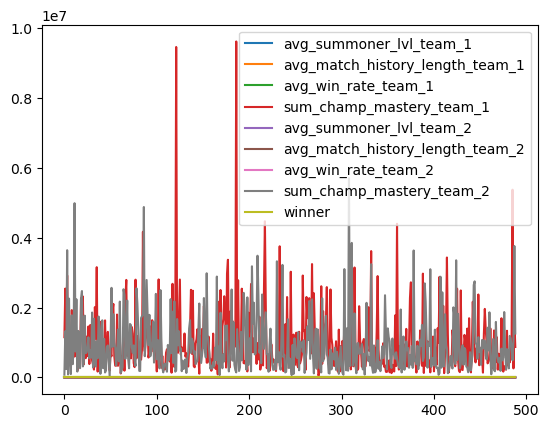

In [160]:
df.plot()

In [161]:
df.describe()

,avg_summoner_lvl_team_1,avg_match_history_length_team_1,avg_win_rate_team_1,sum_champ_mastery_team_1,avg_summoner_lvl_team_2,avg_match_history_length_team_2,avg_win_rate_team_2,sum_champ_mastery_team_2,winner
count,489.000000,489.000000,489.000000,4.890000e+02,489.000000,489.000000,489.000000,4.890000e+02,489.000000
mean,337.300613,19.788139,0.498916,1.011047e+06,336.531288,19.773415,0.501329,9.336285e+05,1.496933
std,113.233301,0.681806,0.040457,9.762992e+05,113.659825,0.834912,0.041460,8.275852e+05,0.500503
min,85.600000,15.000000,0.280000,5.427100e+04,50.800000,13.200000,0.270000,3.985400e+04,1.000000
25%,256.000000,20.000000,0.480000,4.016750e+05,256.200000,20.000000,0.480000,3.495700e+05,1.000000
50%,325.600000,20.000000,0.500000,7.135820e+05,321.400000,20.000000,0.500000,6.959070e+05,1.000000
75%,411.400000,20.000000,0.520000,1.319560e+06,413.000000,20.000000,0.520000,1.152839e+06,2.000000
max,748.600000,20.000000,0.700000,9.608168e+06,763.000000,20.000000,0.650000,5.695470e+06,2.000000


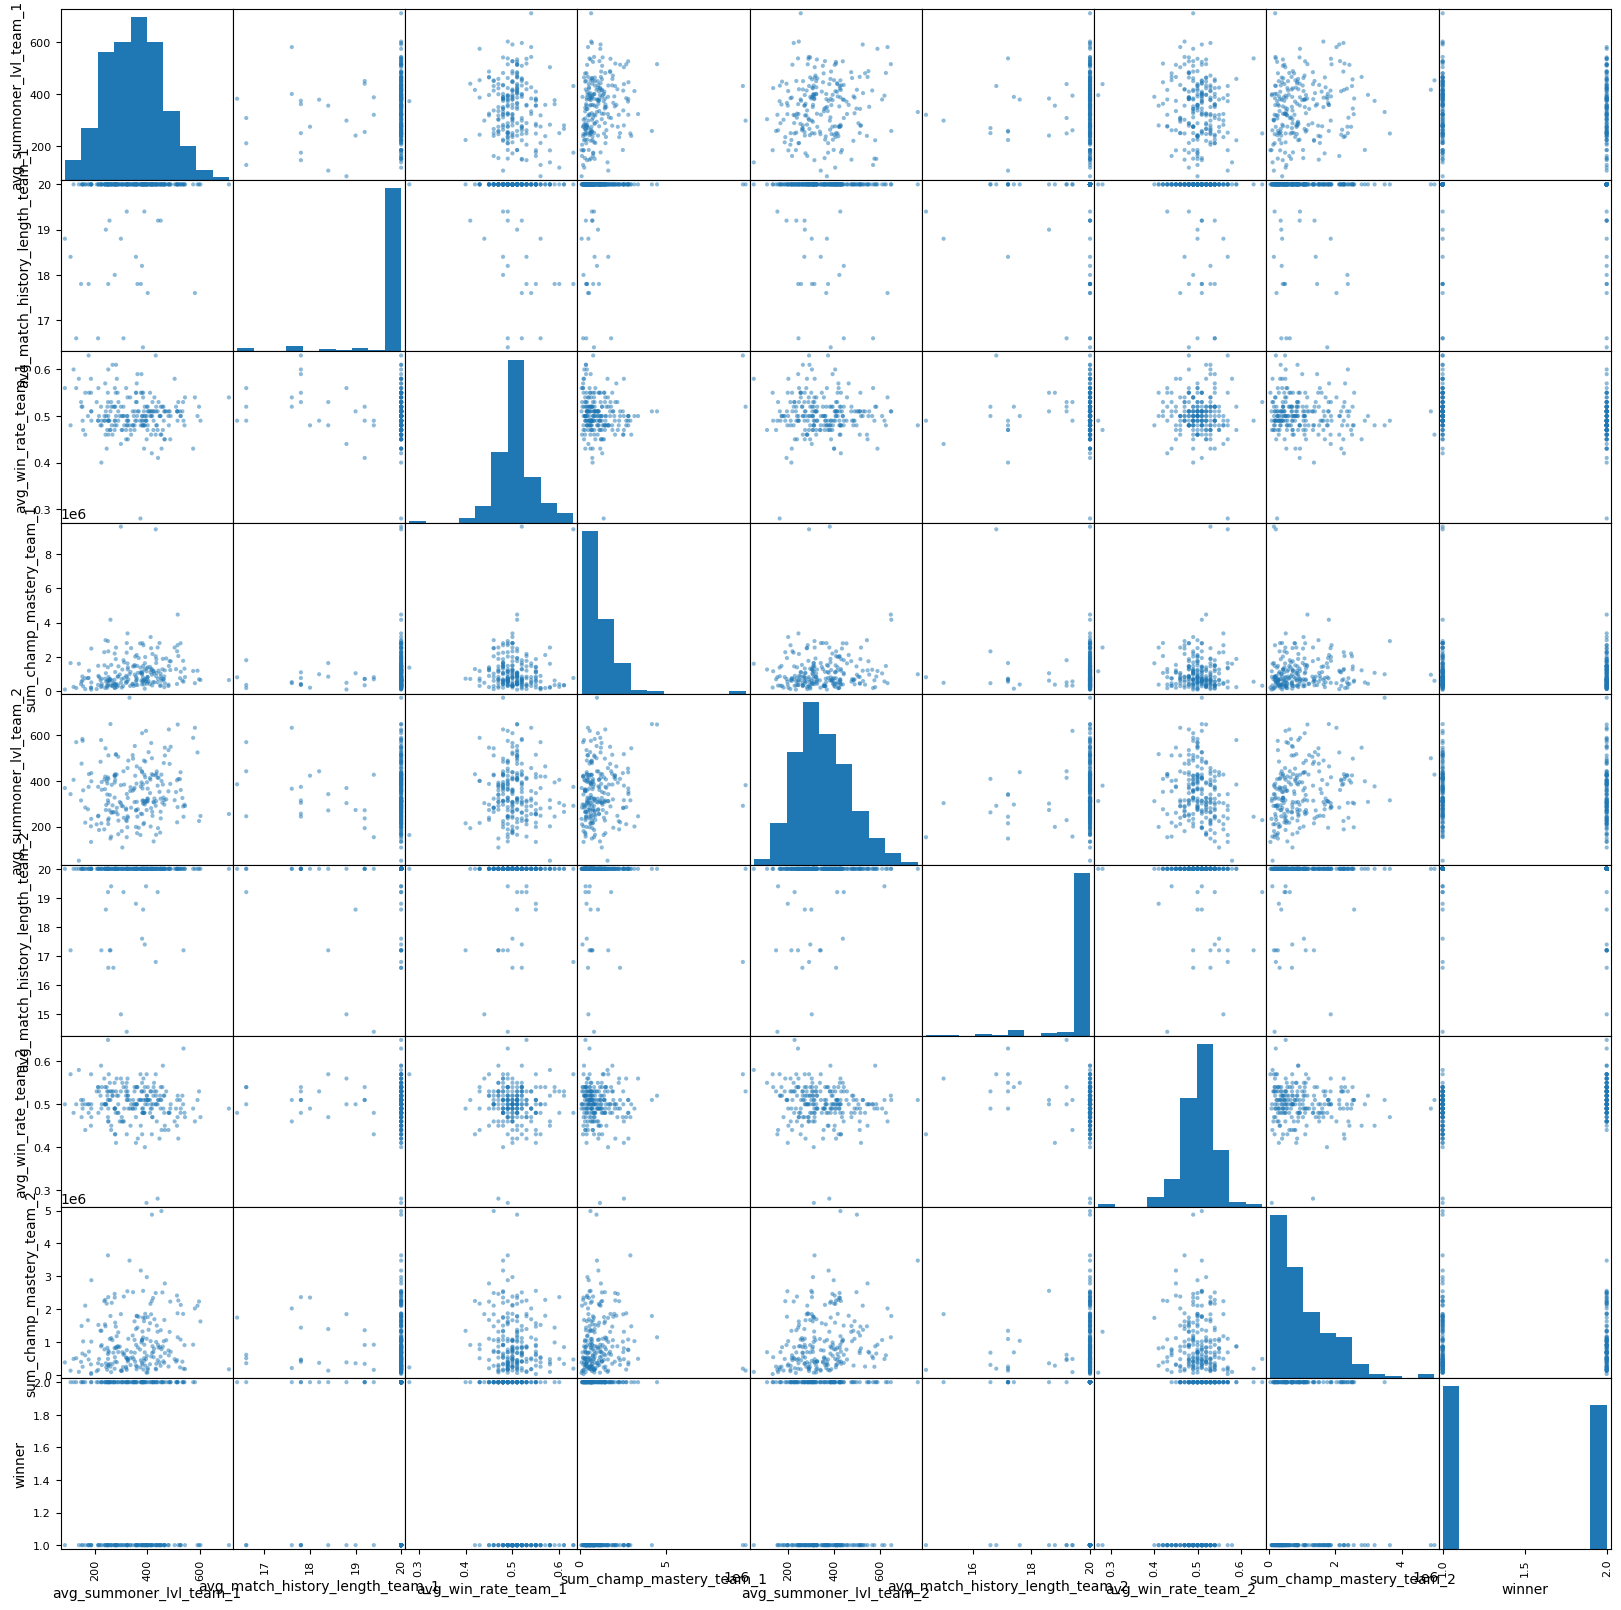

In [108]:
_ = pd.plotting.scatter_matrix(df, figsize=(20,20))

# Training The Model

In [170]:
# X = features
X = df.drop('winner', axis=1)
# y = label
y = df['winner']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
num_features = X_train.shape[1]

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural network model
model = Sequential()

# Add input layer and first hidden layer
model.add(Dense(5, input_shape= (num_features,), kernel_initializer='he_normal', activation='relu'))

# Add second hidden layer
#model.add(Dense(3, activation='softmax'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\Mensun\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [171]:
# Training time
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2685 - loss: 0.3760 - val_accuracy: 0.3163 - val_loss: 0.4207
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3688 - loss: 0.2686 - val_accuracy: 0.3673 - val_loss: 0.2485
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4251 - loss: 0.0994 - val_accuracy: 0.3980 - val_loss: 0.0900
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3993 - loss: -0.2044 - val_accuracy: 0.4286 - val_loss: -0.0598
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4462 - loss: -0.1913 - val_accuracy: 0.4490 - val_loss: -0.2085
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4944 - loss: -0.3089 - val_accuracy: 0.4592 - val_loss: -0.3594
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4862 - loss: -0.5347 - val_accuracy: 0.4592 - val_loss: -0.5185
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4828 - loss: -0.6258 - val_accuracy: 0.4592 - 

# Model Evaulation

In [172]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4898 - loss: -0.9985 
Accuracy: 47.96%
